# Get actives and mols

Get distinct, non-redundant active parent compounds for targets with greater than the minimum required number of such actives.

Add molecules data (RDKit mol, fingerprint and Murko scaffold) and save.

In [1]:
import rdkit.Chem.Scaffolds.MurckoScaffold as MurckoScaffold

from local_utils.rdkit_utils import FP

## Config

In [2]:
# Threshold number of distinct active parent compounds...

min_n_active = 40

In [3]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

##  Get actives

Get list of distinct active compounds (_a.k.a._ 'actives') for those Human targets having at least the minimium required number of actives.


* Compounds are defined in terms of USMILES and targets are defined in terms of symbol/species pairs.


* Note that compounds have been filtered on minumum (10) and maximumn (50) number of heavy atoms.


* See notebook [09_Counts_of_actives_and_symbols_lost](09_Counts_of_actives_and_symbols_lost.ipynb#human_symbols_with_counts) for details on file '`human_symbols_with_counts.pkl`'.


* See notebook [08_Curve_data_actives](08_Curve_data_actives.ipynb) for details of table '`tt_curve_data_actives'` 

In [4]:
# Get Human targets with at least the minimium required number of actives...

targets = pd.read_pickle('human_symbols_with_counts.pkl').query("n_active >= @min_n_active")

targets.shape

(138, 5)

In [5]:
targets.head(1)

,symbol,approved_name,targets,target_class,n_active
0,ABCB1,"ATP-binding cassette, sub-family B (MDR/TAP), member 1","((MDR1, 7), (MDR1, 8), (ATP-binding cassette, sub-family B (MDR/TAP), member 1, 11))",Transporter > Primary active transporter,652


In [6]:
# List of the symbols of interest...

symbols = targets['symbol'].unique().tolist()

len(symbols)

138

In [7]:
actives = pd.read_sql("""
    select
          symbol
        , usmiles
    from
        tt_curve_data_actives
    where
        species = 'Human'
    order by
          symbol
        , usmiles
""", engine)\
    .set_index('symbol', drop=False)\
    .loc[symbols]
    
actives.shape

(167055, 2)

In [8]:
actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


In [9]:
actives['symbol'].unique().size

138

_N.B._ See [SQL/supplementary/actives.sql](SQL/supplementary/actives.sql) for an alternative, SQL-based approach.

## Molecules

Get RDKit molecules, fingerprints and Murko scaffolds for the actives.

In [10]:
# Get unique molecules...

active_mols = actives[['usmiles']].drop_duplicates().set_index('usmiles', drop=False)

# Add molecules and fingerprints (the latter in a Pandas-friendly form)...

PandasTools.AddMoleculeColumnToFrame(active_mols, smilesCol='usmiles', molCol='mol')

active_mols.drop('usmiles', axis=1, inplace=True)

active_mols['FP'] = active_mols['mol'].apply(FP)

# Add cores (i.e. Murko Scaffolds)...

PandasTools.AddMurckoToFrame(active_mols, molCol='mol', MurckoCol='core_smiles', Generic=False)

active_mols.shape

(104749, 3)

In [11]:
assert not any(active_mols[x].isnull().any() for x in ['mol', 'FP', 'core_smiles'])

### Save

In [12]:
actives.shape, active_mols.shape

((167055, 2), (104749, 3))

In [13]:
actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

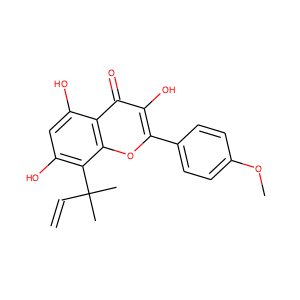

In [14]:
active_mols.head(1)

In [15]:
pickle.dump([actives, active_mols], open('actives.pkl', 'w'))

# actives, active_mols = pickle.load(open('actives.pkl'))

In [27]:
# Add convenience table to RDBMS of 'interesting subset' of active target/compound combinations...

actives.sort(['symbol', 'usmiles']).to_sql('tt_curve_data_actives_subset', engine, if_exists='replace', index=False, dtype={'symbol': VARCHAR2(10), 'usmiles': VARCHAR2(4000)})